In [260]:
import numpy as np
import cupy as cp
import cupyx as cpx
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib
import gc
import time
%matplotlib inline

import os

# checking if gpu is available
genn = np.random.default_rng()
if cp.cuda.is_available():
    print("cuda available")
    gen = cp.random.default_rng()
else:
    print("cuda not available")
    gen = np.random.default_rng()
    cp = np

cuda available


## Simulating null paths

### Gillespie algorithm

The Gillespie algorithm provides a method to simulate a process using only a master equation. Below is an implementation for the two-variable case and a path generated with it.

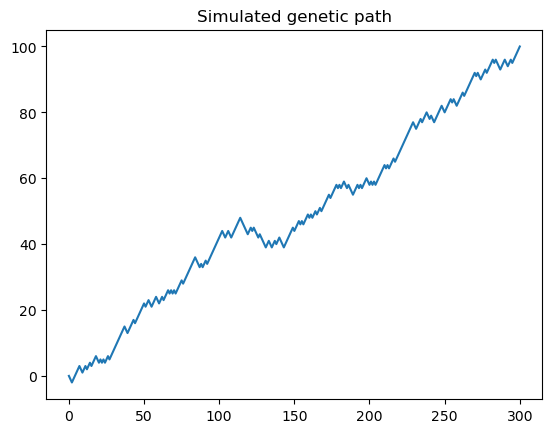

In [242]:
def gillespie_simple(N_m, N_p, M = 1):
    runs = []
    for _ in range(M):
        Ns = [N_m, N_p]
        N = N_m + N_p
        g = [-1, 1]
        cumulative = [0]
        counts = np.array([0, 0]) 
        r2 = gen.uniform(size = N)
        for j in range(N):
            a = [(Ns[i] - counts[i]) / (N - j) for i in range(2)]
            mu = 0
            n = r2[j] - a[mu]
            mu = int(n > 0)

            cumulative.append(cumulative[-1] + g[mu])
            counts[mu] += 1
        runs.append(np.array(cumulative))
    runs = np.transpose(runs)
    return runs

x=gillespie_simple(100,200,1)
plt.plot(x)
plt.title("Simulated genetic path")
plt.show()


Below we have a more optimised implementation of the Gillespie algorithm that can also be ran on a GPU using CUDA. Some simulated paths are shown below.

In [243]:
def gillespie(N_m, N_p, M = 1):
    Ns = [[N_m, N_p]]
    N = N_m + N_p
    Ns = cp.array(Ns).T
    g = cp.array([-1, 1])
    cumulative = cp.zeros([N+1,M])
    counts = cp.zeros([2,M])
    r2 = gen.uniform(size = [N+1,M])
    rang = cp.arange(M)
    for j in range(N):
        a = (Ns - counts) / (N-j)
        n = r2[j] - a[0]
        mu = (n > 0) + 0
        cumulative[j+1] = cumulative[j] + g[mu]
        counts[mu, rang] += 1
    return cumulative.T

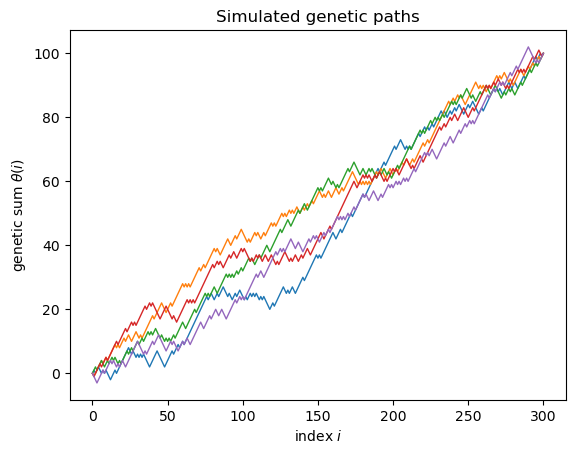

In [244]:
N_m = 100
N_p = 200
N = N_m + N_p
M = 5
j = np.arange(N+1)
x = gillespie(N_m, N_p, M).get()

fig,ax = plt.subplots()
ax.plot(j, x.T,linewidth=1,alpha=1)
# plt.ylim([-200,200])
ax.set_title("Simulated genetic paths")
ax.set_xlabel(r"index $i$")
ax.set_ylabel(r"genetic sum $\theta(i)$")
plt.savefig('Figures/Simulated null genetic paths.pdf', backend='pgf')
plt.show()

# max = np.max(x,axis=0)
# min = np.min(x,axis=0)
# med = np.median(x,axis=0)
# plt.plot(j, max,label="max")
# plt.plot(j, med,label="median")
# plt.plot(j, min,label="min")
# plt.legend()
# plt.savefig("Figures/Simulated null genetic path stats.pdf", backend='pgf')
# plt.show()

### Verifying the closed-form expression of the distribution of the null path.

In [245]:
# Finds empirical probability that a null path with parameters N_m, N_p is equal to theta at index j.
def empirical_test(N_m, N_p, theta,j, M):
    runs = gillespie(N_m, N_p, M)
    successes = runs[:,j] == theta
    return cp.sum(successes) / M

In [246]:
# testing analytical distribution for two variable case empirically
N_m = 50
N_p = 50
N = N_p + N_m
M = 1000000
j = 98
theta = (N_p - N_m) * j / N
print(f'target theta = {theta}')


suc = (theta + j) / 2 # the number of +1 steps to get theta
if suc % 1 == 0:
    predicted = sp.special.comb(N_p, suc) * sp.special.comb(N - N_p, j - suc) / sp.special.comb(N, j)
    print(f'Predicted probability that theta({j}) = {theta} is {np.round(predicted,4)}')
else:
    predicted = 0
    print("impossible")

test = empirical_test(N_m, N_p, theta,j, M)
print(f'Empirical probability that theta({j}) = {theta} is {np.round(test,4)}')
error = (predicted - test) / test 
print(f'Relative error: {np.round(error,8)}')

target theta = 0.0
Predicted probability that theta(98) = 0.0 is 0.5051
Empirical probability that theta(98) = 0.0 is 0.5049
Relative error: 0.00036743


## Intersections with the default genetic path

Empirical estimates

In [247]:
# find empirical probability of intersection (with null path) at each index and number of intersections
def intersection_density(N_m, N_p, M): 
    N = N_p + N_m
    x0 = cp.arange(N+1) * (N_p - N_m) / N
    intersections = cp.zeros([M,N+1])
    x = gillespie(N_m, N_p, M)
    y = x - x0
    intersections = y == 0
    
    inter_number = cp.sum(intersections[:], axis = 1) - 1
    inters = cp.argwhere(intersections == 1).T[1]
    return inters.get(), inter_number.get()

def intersection_density_KS(N_m, N_p, M): 
    N = N_p + N_m
    x0 = cp.arange(N+1) * (N_p - N_m) / N
    intersections = cp.zeros([M,N+1])
    x = gillespie(N_m, N_p, M)
    y = x - x0
    intersections = y == 0
    
    inter_number = cp.sum(intersections[:], axis = 1) - 1
    inters = np.nonzero(intersections.get())
    return inters, inter_number.get()

# def intersection_density(n_ratio, N, M): 
#     Ns = [int(n_ratio * N / (n_ratio + 1))]
#     Ns.append(N-Ns[0])
#     x0 = cp.arange(N+1) * (Ns[0] - Ns[1]) / N
#     intersections = cp.zeros([M,N+1])
#     x = gillespie(n_ratio, N, M)
#     y = x - x0
#     # intersections[:,1:] = y[:,1:] == 0
#     intersections = y == 0

#     inter_number = cp.sum(intersections, axis = 1)
#     inters = cp.argwhere(intersections == 1).T[1] / N

#     return inters.get(), inter_number.get()

Recursive algorithm for finding the distribution of the number of intersections with default path.

In [248]:
# fastest (vectorised in l loop)
def intersect_num_dp(N_m, N_p, J=-1, K=-1):

    def f(N, N_p, ind, theta):
        n_p = (ind + theta) / 2
        return sp.stats.hypergeom.pmf(k=n_p, N=ind, n=N_p, M=N)
    
    N = N_m + N_p
    d = np.gcd(N,N_p)
    a = int(N / d)
    if J == -1:
        J = N
    if K == -1:
        K = d
    J = int(J/a)

    # we define probs[j,l,k] = p(z_j = k, theta(aj) = l)
    probs = np.zeros([J+1, N + 1, J+1])
    probs[0,0,0] = 1
    null = (N_p - N_m) / N
    
    starttime = time.time()
    # for k = 0
    for j in range(1,J+1):
        ja = j * a
        N_sub = N - a * (j-1)
        for s in range(np.max([-ja, -N_m]), np.min([ja, N_p])+1):
            if s / ja == null:
                continue
            l = np.arange(np.max([s-a, -(ja - a), -N_m]), np.min([s+a, ja - a, N_p])+1)
            N_sub_p = N_p - (l + ja - a) / 2
            
            valid = np.where((N_sub_p %1 == 0) * (N_sub_p <= N_sub) * (N_sub_p >= 0), 1, 0)

            step = np.multiply(f(N_sub, N_sub_p, a, s-l), valid)
            step = np.nan_to_num(step)

            probs[j,s,0] = step @ probs[j-1,l,0]

    firstloop = time.time()
    print("Time to complete first loop: ", firstloop - starttime)
    
    for j in range(1,J+1):
        ja = j * a
        N_sub = N - a * (j-1)
        for s in range(np.max([-ja, -N_m]), np.min([ja, N_p])+1):
            l = np.arange(np.max([s-a, -(ja - a), -N_m]), np.min([s+a, ja - a, N_p])+1)
            N_sub_p = N_p - (l + ja - a) / 2
            
            valid = np.where((N_sub_p %1 == 0) * (N_sub_p <= N_sub) * (N_sub_p >= 0), 1, 0)

            step = np.multiply(f(N_sub, N_sub_p, a, s-l), valid)
            step = np.nan_to_num(step)
            k = np.arange(1,j+1)

            if s / ja == null:
                probs[j,s,k] = step @ probs[j-1,l][:,k-1]
            else:
                probs[j,s,k] = step @ probs[j-1,l][:,k]

    secondloop = time.time()
    print("Time to complete second loop: ", secondloop - firstloop)
    ptot = np.sum(probs[-1], axis = 0)
    # return np.concatenate([np.array([0]), ptot[-1]], axis = 0)
    return ptot


# N_m = 50
# N_p = 50

# d = np.gcd(N_m, N_p)
# a = (N_m + N_p) / d

# M = 200000
# _, intnums = intersection_density(N_m, N_p, M)
# y = np.unique_counts(intnums)[1]/M

# x = intersect_num_dp(N_m, N_p)
# print(x[1:len(y)+1])

# print((y - x[1:len(y)+1])/y)

Recursive algorithm for balanced design case

In [249]:
# for N_+ = N_-
def intersect_num_dp_even(N,k,l = -1):
    '''Assume N+ = N-'''
    if l == -1:
        l = N
    if l % 2 != 0:
        print("non-int")

    def f(N,c,a):
        return (1 / ((a - c)*2 - 1)) * sp.special.comb((N - c * 2)/ 2, a-c) ** 2 / sp.special.comb(N - 2 * c, 2 * (a-c))

    dp = np.zeros([int(l/2)+1, k]) # P j_b = a n_r
    dp[0,0] = 1
    dp[1,1] = sp.special.comb(N / 2, 1) * sp.special.comb(N / 2, 1) / sp.special.comb(N, 2)
    for i in range(2, int(l/2)+1):
        for b in range(1,k):
            if b <= i:
                x = [dp[c,b-1] * f(N, c, i) for c in range(i)]
                dp[i,b] = np.sum(x)
    dp = np.concatenate([np.zeros([int(l/2 + 1),1]),dp],axis=1)
    return dp[-1][1:]

Using the analytical result for the distribution of the null path, we can find exactly the probability of intersection

In [250]:
# finds exact probability of intersection at each index
def null_intersection_exact(N_m, N_p):
    N = N_p + N_m
    probs = []
    for j in range(N+1):
        prob = float(sp.stats.hypergeom.pmf(k=j * N_p / N, N=j, n=N_p, M=N))
        probs.append(prob)
    return probs

Below we produce plots comparing the prediction of the analytical results against empirical results obtained through the Gillespie algorithm.

In [240]:
# Defining some simple functions to produce nice plots with the above functions for any N_m, N_p
def plot_inters_empirical(M, N_m, N_p):
    N = N_m + N_p
    inters, _ = intersection_density(N_m, N_p, M)
    inters = np.histogram(inters, bins=N+1, range = (0,N+1))

    fig, ax = plt.subplots()
    fig.set_figwidth(8)
    fig.set_figheight(4)
    # ax.set_title(f"Empirical null path intersection probabilities, $N_-$ = {N_m}, $N_+$ = {N_p}, {M} null paths")
    ax.set_xlabel("$i$")
    ax.set_ylabel(r"Probability of intersection, $\; P(\theta(i) = \theta_0(i))$")

    ax.bar(inters[1][:-1]-0.5, inters[0]/M, align='edge',width=1)
    return fig, ax

def plot_inters_exact(N_m, N_p):
    N = N_m + N_p
    inters = null_intersection_exact(N_m, N_p)

    fig, ax = plt.subplots()
    fig.set_figwidth(8)
    fig.set_figheight(4)
    # ax.set_title(f"Empirical null path intersection probabilities, $N_-$ = {N_m}, $N_+$ = {N_p}, {M} null paths")
    ax.set_xlabel("$i$")
    ax.set_ylabel(r"Probability of intersection, $\; P(\theta(i) = \theta_0(i))$")

    ax.bar(np.arange(N+1)-0.5, inters, align='edge',width=1)
    return fig, ax

def plot_internum_empirical(M, N_m, N_p, fig=-1, ax=-1):
    _, internum = intersection_density(N_m, N_p, M)
    internum = np.histogram(internum, bins = np.max(internum) + 1, density = True, range = [-0.5, np.max(internum) + 0.5])

    if fig == -1:
        fig, ax = plt.subplots()
    fig.set_figwidth(8)
    fig.set_figheight(4)
    # ax.set_title(f"Empirical null path intersection probabilities, $N_-$ = {N_m}, $N_+$ = {N_p}, {M} null paths")
    ax.set_xlabel("Total number of intersections $k$")
    ax.set_ylabel(r"Probability of $k$ intersections")

    ax.bar(internum[1][:-1], internum[0], align='edge', width=1, label='empirical estimate')
    return fig, ax

def plot_internum_exact(N_m, N_p, fig=-1, ax=-1):
    internum = intersect_num_dp(N_m, N_p)

    if fig == -1:
        fig, ax = plt.subplots()
    fig.set_figwidth(8)
    fig.set_figheight(4)
    # ax.set_title(f"Empirical null path intersection probabilities, $N_-$ = {N_m}, $N_+$ = {N_p}, {M} null paths")
    ax.set_xlabel("Total number of intersections $k$")
    ax.set_ylabel(r"Probability of $k$ intersections")
    internum = internum[:np.max(np.argwhere(internum>10**-7))]
    ax.bar(np.arange(len(internum))-0.5, internum, align='edge', width=1)
    return fig, ax

Time to complete first loop:  1.4500744342803955
Time to complete second loop:  1.571258544921875


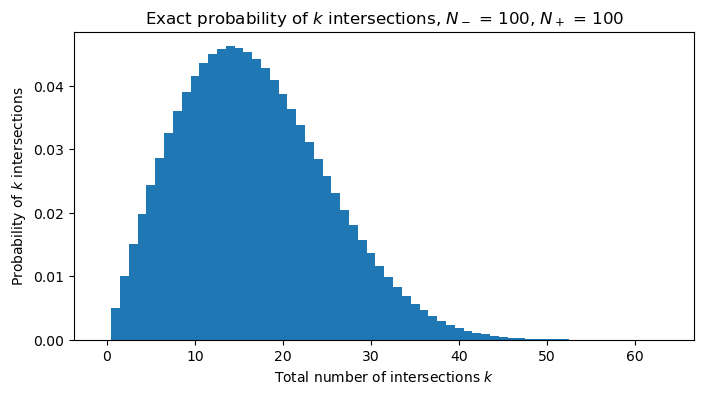

In [253]:
N_m = 100
N_p = 100
N = N_m + N_p

fig,ax = plot_internum_exact(N_m,N_p)
# plt.savefig(f'figures/Only exact probability of $k$ intersections, $N_-$ = {N_m}, $N_+$ = {N_p}.pdf', backend='pgf')
ax.set_title(f'Exact probability of $k$ intersections, $N_-$ = {N_m}, $N_+$ = {N_p}')
plt.show()

empirical


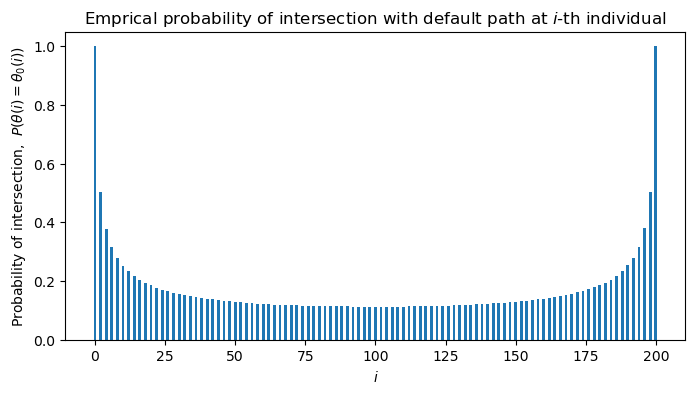

In [255]:
N_m = 100
N_p = 100
N = N_m + N_p
M = 1000000

print("empirical")
fig,ax = plot_inters_empirical(M,N_m,N_p)
plt.title("Emprical probability of intersection with default path at $i$-th individual")
plt.savefig(f'figures/Empirical null path intersection probabilities, $N_-$ = {N_m}, $N_+$ = {N_p}, {M} null paths.pdf', backend='pgf')
plt.show()

exact


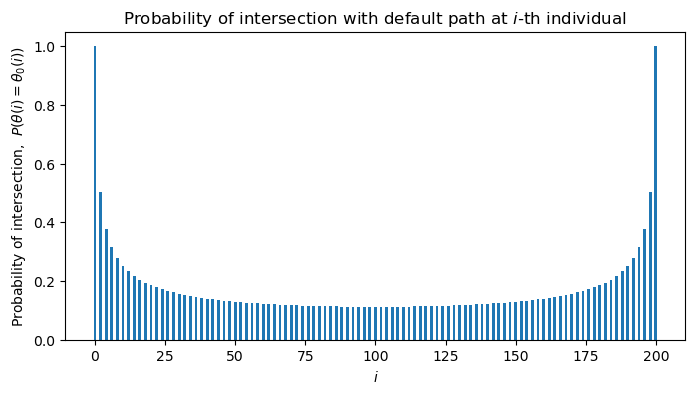

In [254]:
N_m = 100
N_p = 100

print("exact")
fig, ax = plot_inters_exact(N_m,N_p)
plt.title("Probability of intersection with default path at $i$-th individual")
plt.savefig(f'Exact null path intersection probabilities, $N_-$ = {N_m}, $N_+$ = {N_p}.png', backend='pgf',dpi=500)
plt.show()

In [256]:
N_m = 100
N_p = 100
N = N_m + N_p

internum = intersect_num_dp(N_m, N_p)[:50]

Time to complete first loop:  1.4831268787384033
Time to complete second loop:  1.5903491973876953


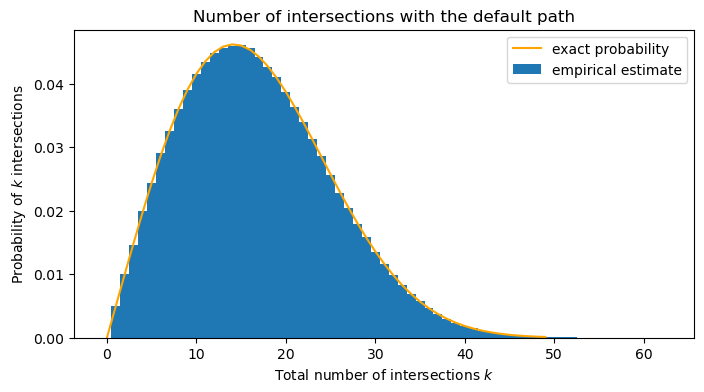

In [ ]:
M = 1000000

fig,ax = plot_internum_empirical(M,N_m,N_p)
ax.plot(internum[:50], c='orange', label='exact probability')
ax.legend()
ax.set_title('Number of intersections with the default path')
plt.savefig(f'Probability of $k$ intersections, $N_-$ = {N_m}, $N_+$ = {N_p}, {M} null paths.png', backend='pgf', dpi=500)
plt.show()

In [257]:
# N_m = 100
# N_p = 100
# N = N_m + N_p
# M = 1000000

# fig,ax = plt.subplots()
# # fig,ax = plot_internum_empirical(M,N_m,N_p)
# ax.plot(internum[:50], c='orange')
# ax.set_xlabel("Total number of intersections $k$")
# ax.set_ylabel(r"Difference")
# # ax.legend()
# plt.savefig(f'figures/Difference exact sols Probability of $k$ intersections, $N_-$ = {N_m}, $N_+$ = {N_p}, {M} null paths.pdf', backend='pgf')
# plt.show()

We can also use the Kolmogorov-Smirnov test. The KS statistic takes a value between 0 and 1, and converges to 0 almost surely with more samples for continuous random variables. The quantity we sample is the index of a randomly chosen intersection. The predicted distribution is found easily, but it is not a continuous distribution, since the index takes an integer value between $0$ and $N$. This introduces a small bias, however, this can be corrected for.

In [ ]:
#KS test for intersection distribution

N_m = 20000
N_p = 20000
M = 1000

N = N_m + N_p

emp_inters, _ = intersection_density(N_m, N_p, M)
probs = null_intersection_exact(N_m,N_p)
probs = probs / np.sum(probs)
probs = np.round(np.cumsum(probs),5)
p = lambda x: probs[x]

res = sp.stats.kstest(emp_inters, p)
print(res)

KstestResult(statistic=np.float64(0.010061627332786427), pvalue=np.float64(1.287729509805256e-22), statistic_location=np.int64(7402), statistic_sign=np.int8(-1))


In [296]:
stat = res[0]
pval = res[1]
print(f'We obtain KS statistic of {stat} with p value {pval}.\n')
print('The statistic is very close to zero, and the small difference can be attributed\n'
      'mainly to the discreteness of the quantity, with a small contribution from sample variance')

We obtain KS statistic of 0.010061627332786427 with p value 1.287729509805256e-22.

The statistic is very close to zero, and the small difference can be attributed
mainly to the discreteness of the quantity, with a small contribution from sample variance


Above we consider very few choices of $N_-$ and $N_+$, but we can also find the distributions of the number and location of intersections for other parameter values. 
Below are some other possible values to show that the results hold in general. 

[7 6 2 ... 4 2 6]
Time to complete first loop:  0.20642757415771484
Time to complete second loop:  0.22234201431274414


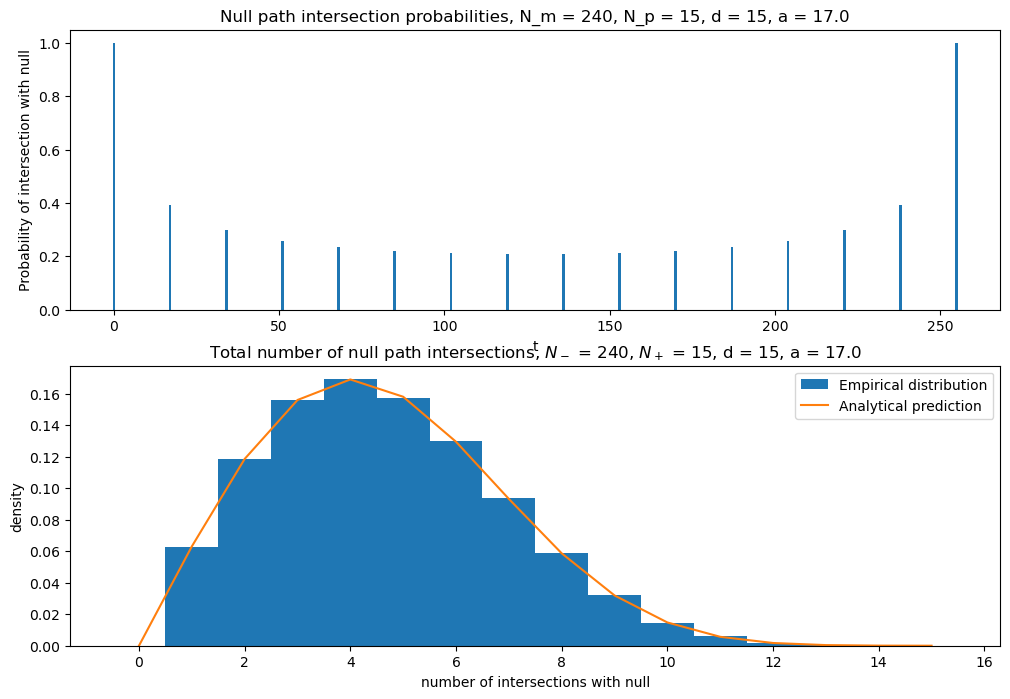

[18 23 25 ... 25 10 29]
Time to complete first loop:  1.5200402736663818
Time to complete second loop:  1.5693104267120361


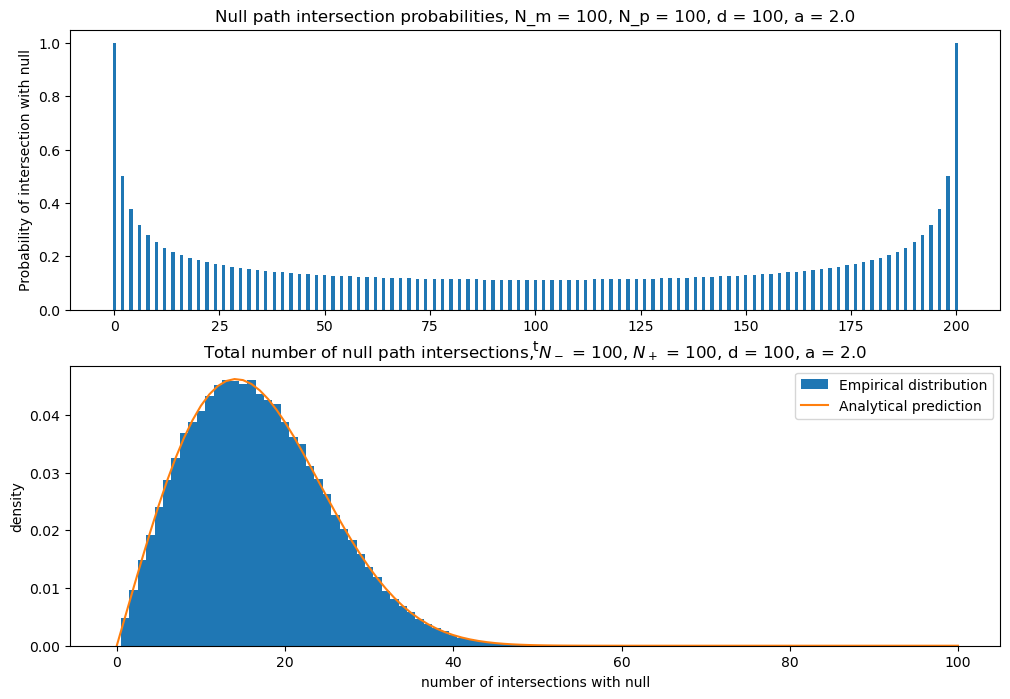

[ 8  8 23 ... 12  7 10]
Time to complete first loop:  6.002956867218018
Time to complete second loop:  6.503393888473511


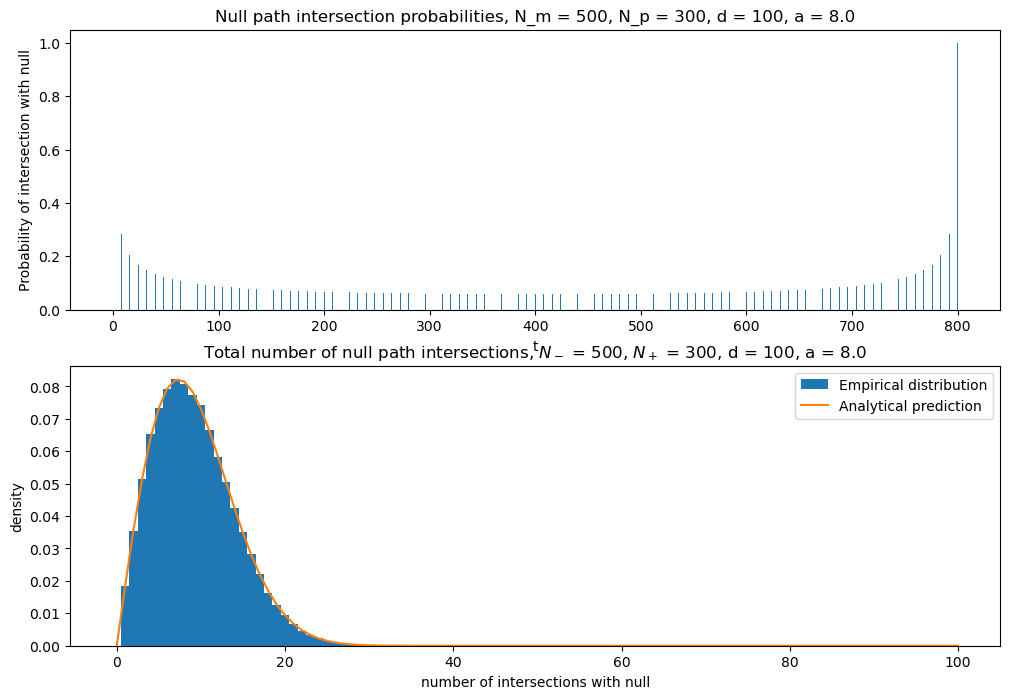

[ 4  7 16 ...  5  6 14]
Time to complete first loop:  4.905479669570923
Time to complete second loop:  5.357626914978027


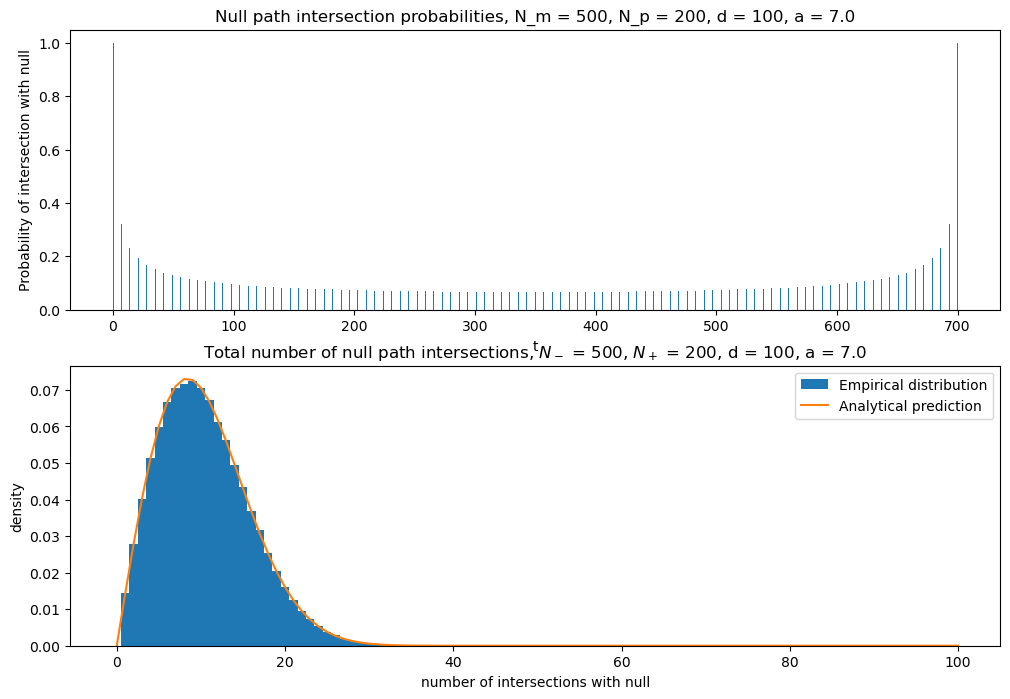

[2 5 1 ... 5 5 5]
Time to complete first loop:  3.9901506900787354
Time to complete second loop:  4.281430959701538


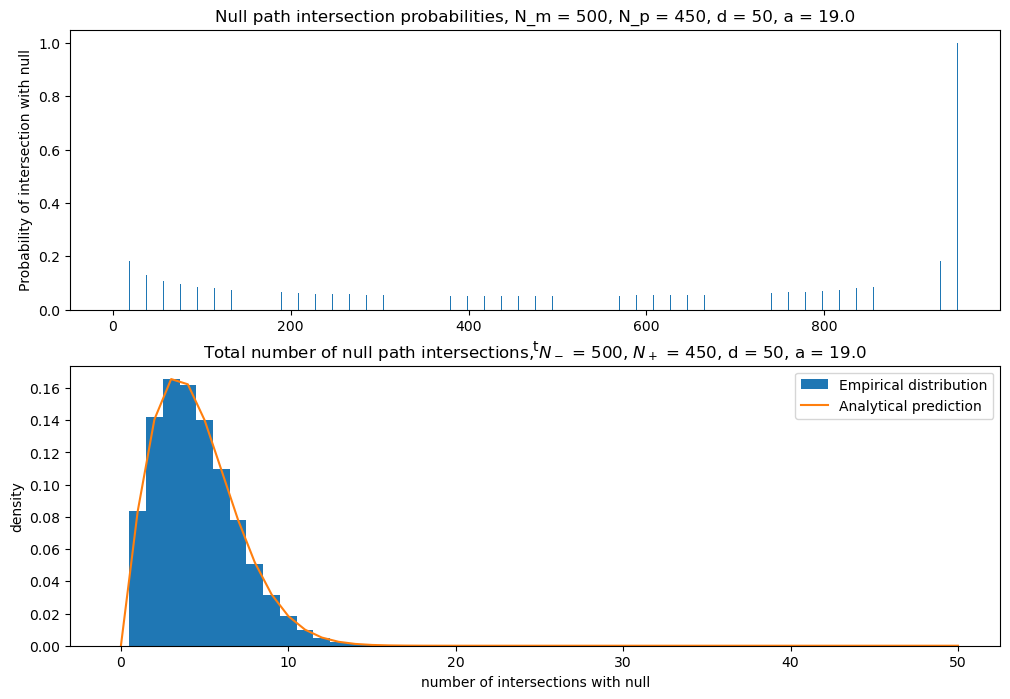

[1 1 1 ... 1 1 1]
Time to complete first loop:  0.14232420921325684
Time to complete second loop:  0.15128684043884277


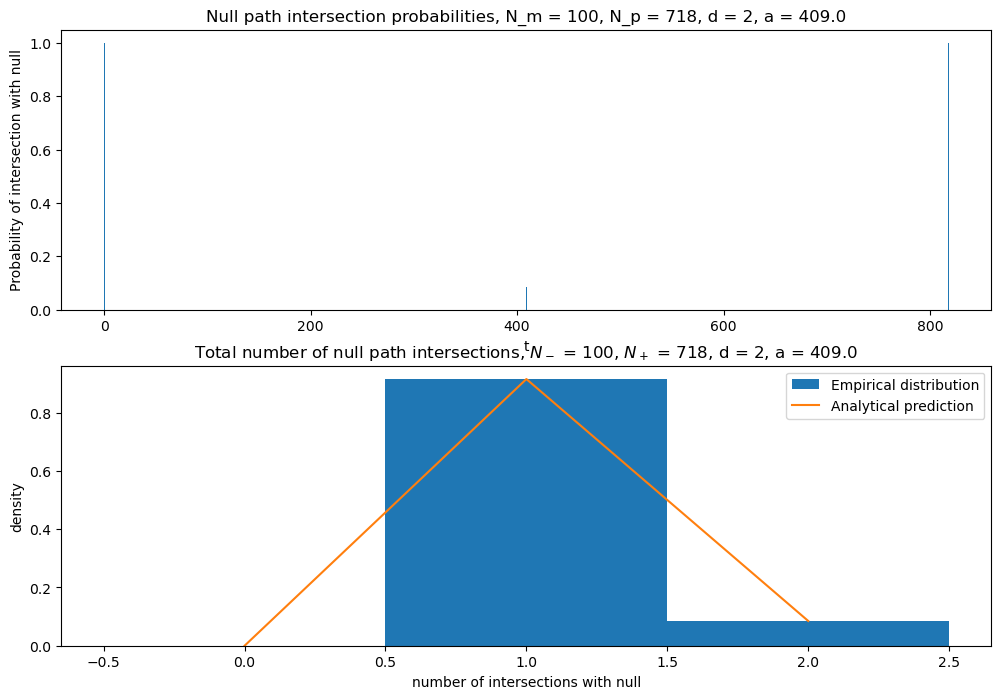

In [301]:
# Exact intersection probabilities 

N_ps = [15, 100, 300, 200, 450, 718]
N_ms = [15 * 16, 100, 500, 500, 500, 100]

M = 200000

for i in range(len(N_ps)):
    N_p = N_ps[i]
    N_m = N_ms[i]
    N = N_p + N_m

    d = np.gcd(N, N_p)
    a = N / d
    b = N_p / d


    _, inter_number = intersection_density(N_m, N_p, M)
    print(inter_number)
    
    fig, axs = plt.subplots(2,1)
    fig.set_figwidth(12)
    fig.set_figheight(8)
    x = np.arange(N+1)
    axs[0].bar(x,null_intersection_exact(N_m, N_p))
    axs[0].set_title(f"Null path intersection probabilities, N_m = {N_m}, N_p = {N_p}, d = {d}, a = {a}")
    axs[0].set_xlabel("t")
    axs[0].set_ylabel("Probability of intersection with null")
    
    axs[1].hist(inter_number, bins = np.max(inter_number) + 1, density = True, range = [-0.5, np.max(inter_number) + 0.5], label="Empirical distribution")
    axs[1].set_title(f"Total number of null path intersections, $N_-$ = {N_m}, $N_+$ = {N_p}, d = {d}, a = {a}")
    axs[1].set_xlabel("number of intersections with null")
    axs[1].set_ylabel("density")


    # print(d)
    # print(N/n_ratio)
    # print(N / (N/d - 1))
    
    if int(N / (N/d - 1)) >= 2:
        # axs[1].plot(np.arange(k+1), intersect_num_dp(int(N / (N/d - 1) / 2)*2, k))
        # axs[1].plot(np.arange(k+1) * 2 / a, intersect_num_dp(N_m * 2, k) * a / 2)
        axs[1].plot(intersect_num_dp(N_m, N_p, K = 60), label="Analytical prediction")

    axs[1].legend()
    plt.show()

    del inter_number
    gc.collect()
    cp._default_memory_pool.free_all_blocks()

Let's investigate the number of intersections further. Below we produce plots that cover many choices for $N_-$ and $N_+$. 

In [302]:
def heat(N_ms, N_ps):
    means = np.zeros([len(N_ps), len(N_ms)])
    for j in range(len(N_ms)):
        N_m = N_ms[j]
        for i in range(len(N_ps)):
            N_p = N_ps[i]
            probs = null_intersection_exact(N_m,N_p)
            means[i,j] = (np.sum(probs)-1) # / (N_m + N_p) # keeps 
    return means

def heatvar(N_ms, N_ps, M=10000):
    vars = np.zeros([len(N_ps), len(N_ms)])
    for j in range(len(N_ms)):
        N_m = N_ms[j]
        for i in range(len(N_ps)):
            N_p = N_ps[i]
            _, intrsct_nums = intersection_density(N_m, N_p, M)
            vars[i,j] = cp.var(intrsct_nums)
    return vars

In [ ]:
N_ms = np.arange(1,201)
N_ps = np.arange(1,201) 

# If running for the first time, uncomment the lines below
# After running for the first time, you can comment out the next four lines to save time

# ---------------------------------------------------

# y = heat(N_ms,N_ps)
# x = heatvar(N_ms,N_ps)
# np.save('x200', x)
# np.save('y200', y)

x = np.load('x200.npy')
y = np.load('y200.npy')

z = np.sqrt(x)/y

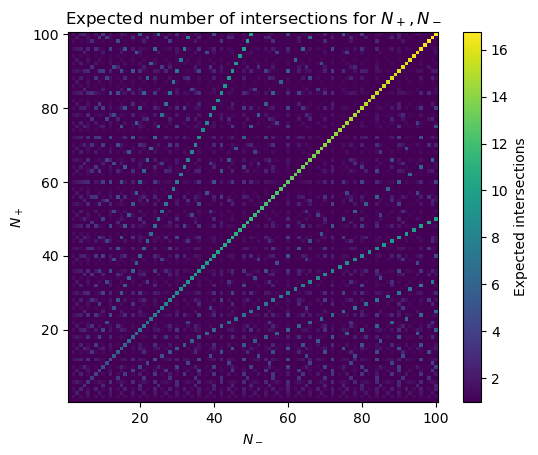

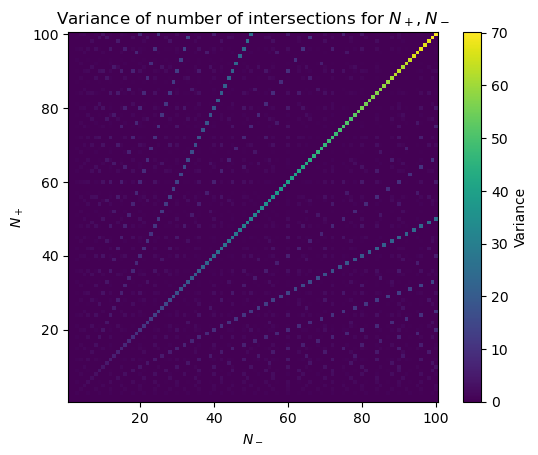

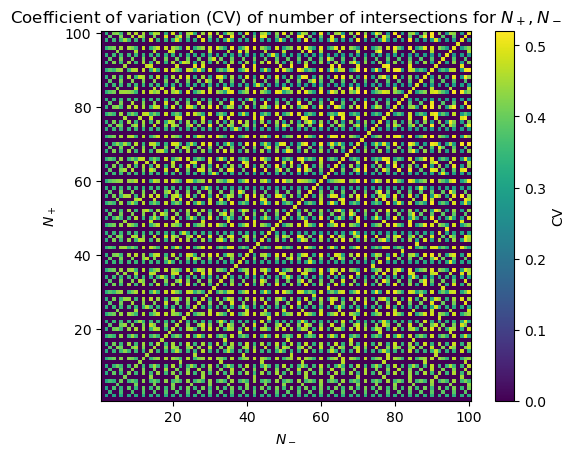

In [314]:
B_ms = [1,100]
B_ps = [1,100]

fig, ax = plt.subplots()
# fig.set_figwidth(11)
# fig.set_figheight(4)
im_mean = ax.imshow(y[:B_ms[-1],:B_ps[-1]], origin='lower', extent=(B_ms[0]-0.5, B_ms[-1]+0.5, B_ps[0]-0.5, B_ps[-1]+0.5),norm='linear')
ax.set_xlabel('$N_-$')
ax.set_ylabel('$N_+$')
ax.set_title(f"Expected number of intersections for $N_+,N_-$")
plt.colorbar(mappable=im_mean, label = "Expected intersections")
plt.savefig(f"Figures/mean intersection number heatmap {B_ms[-1],B_ps[-1]}.pdf",backend="pgf")

fig2,ax2 = plt.subplots()
im_var = ax2.imshow(x[:B_ms[-1],:B_ps[-1]], origin='lower', extent=(B_ms[0]-0.5, B_ms[-1]+0.5, B_ps[0]-0.5, B_ps[-1]+0.5),norm='linear')
ax2.set_xlabel('$N_-$')
ax2.set_ylabel('$N_+$')
ax2.set_title("Variance of number of intersections for $N_+,N_-$")
plt.colorbar(mappable=im_var, label="Variance")
plt.savefig(f"Figures/variance of intersection number heatmap {B_ms[-1],B_ps[-1]}.pdf",backend="pgf")
plt.show()

fig1, ax1 = plt.subplots()
# fig1.set_figwidth(7)
# fig1.set_dpi(500)
im_cov = ax1.imshow(z[:B_ms[-1],:B_ps[-1]], origin='lower', extent=(B_ms[0]-0.5, B_ms[-1]+0.5, B_ps[0]-0.5, B_ps[-1]+0.5),norm='linear', interpolation=None)
ax1.set_xlabel('$N_-$')
ax1.set_ylabel('$N_+$')
ax1.set_title("Coefficient of variation (CV) of number of intersections for $N_+,N_-$")
plt.colorbar(mappable=im_cov,label="CV")
plt.savefig(f"Figures/Intersection CV {B_ms[-1],B_ps[-1]}.pdf", backend="pgf")
print("")
plt.show()

In [ ]:
# def means_single(N_ms, N_ps):
#     means = np.zeros([len(N_ps)])
#     for j in range(len(N_ms)):
#         N_m = N_ms[j]
#         N_p = N_ps[j]
#         probs = null_intersection_exact(N_m,N_p)
#         means[j] = (np.sum(probs)-1) # / (N_m + N_p) # keeps 
#     return means

# def vars_single(N_ms, N_ps, M=10000):
#     vars = np.zeros([len(N_ps)])
#     for j in range(len(N_ms)):
#         N_m = N_ms[j]
#         N_p = N_ps[j]
#         _, intrsct_nums = intersection_density(N_m, N_p, M)
#         vars[j] = cp.var(intrsct_nums)
#     return vars

In [ ]:
# N_ps = np.arange(1,500)
# N_ms = 3 * N_ps
# x = means_single(N_ms, N_ps)
# y = vars_single(N_ms, N_ps, M=100000)

In [315]:
# plt.plot((np.sqrt(y)/x))
# plt.show()
# plt.plot(np.sqrt(y), label='y')
# plt.plot(x, label='x')
# plt.legend()
# plt.show()

In [ ]:
# def legend_without_duplicate_labels(ax):
#     handles, labels = ax.get_legend_handles_labels()
#     unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
#     ax.legend(*zip(*unique))

# def parametric(n_ratio, N, ax, c = None):

#     x = gillespie(n_ratio, N).get()[0]
#     seq = np.array(x[1:] < x[:-1]) * 1
#     parametric = [[0],[0]]
#     for i in seq:
#         parametric[i].append(parametric[i][-1] + 1)
#         parametric[i-1].append(parametric[i-1][-1])
#     parametric = np.array(parametric) / N
    
#     ax.plot(parametric[0], parametric[1], label = f' +/- ratio={n_ratio}', c=c)
#     ax.set_title("Path in parametric axes")
#     ax.set_xlabel("x+")
#     ax.set_ylabel("x-")
#     return parametric

# def parametric_shifted(n_ratio, N, path, ax):
#     Ns = [int(n_ratio * N / (n_ratio + 1))]
#     Ns.append(N-Ns[0])

#     # shift by null path
#     t = np.linspace(0, 1, N+1)
#     shift_plus = Ns[0] / N * t
#     shift_minus = Ns[1] / N * t
#     x = path[0] - shift_plus
#     y = path[1] - shift_minus


#     points = np.array([x, y]).transpose().reshape(-1, 1, 2)
#     # set up a list of segments
#     # segs = np.concatenate([points[:-1],points[1:]],axis=1)
#     segs = np.concatenate([points[:-2], points[1:-1], points[2:]], axis=1)

#     # make the collection of segments
#     lc = LineCollection(segs, cmap=plt.get_cmap('viridis'))

#     lc.set_array(t)  # color the segments by our parameter

#     # plot the collection

#     ax.add_collection(lc)  # add the collection to the plot

#     a = list(ax.get_xlim())
#     b = list(ax.get_ylim())
#     a = [np.min([a[0], x.min()]), np.max([a[1], x.max()])]
#     b = [np.min([b[0], y.min()]), np.max([b[1], y.max()])]

#     ax.set_xlim(a)
#     ax.set_ylim(b)

#     ax.set_title("Parametric path shifted by null path")
#     ax.set_xlabel("y+")
#     ax.set_ylabel("y-")

#     return np.array([x, y])

### Non-zero gene effects (Non-null paths)

In [820]:
# generating non-null paths
def gen_normal(mean, var, N_m, N_p, N_0 = 0):
    if len(mean) == 2:
        mean = np.concat([mean, [0]])
        var = np.concat([var, [0]])

    std = np.sqrt(var)
    pheno = np.concat([genn.normal(mean[0], std[0], size = N_m), genn.normal(mean[1], std[1], size = N_p), genn.normal(mean[2], std[2], size = N_0)])
    order = np.argsort(pheno)
    unordered = np.concat([-np.ones(N_m), np.zeros(N_0), np.ones(N_p)])
    order = unordered[order]
    pheno = [pheno[:N_m], pheno[N_m:N_m+N_p], pheno[N_m + N_p:]]
    path = np.concat([[0],np.cumsum(order)])
    return path, pheno

def gen_life_winter(effect, base_rate, N_m, N_p):
    base_rate = np.ones(2) * base_rate
    winter_rate = base_rate
    # winter_rate[1] = 1 - (1-effect)*(1 - winter_rate[1])
    winter_rate[1] *= (1-effect)
    summer_rate = winter_rate[::-1]
    alive = np.array([N_m,N_p])
    order = np.array([])
    i = 0
    while True:
        if i%2 == 1:
            rate = winter_rate
        else:
            rate = summer_rate
        dead_m = np.random.binomial(n=alive[0], p=rate[0])
        dead_p = np.random.binomial(n=alive[1], p=rate[1])
        dead = [-1]*dead_m + [1]*dead_p
        dead = genn.permutation(dead)
        order = np.concat([order, dead])

        alive[0]-=dead_m
        alive[1]-=dead_p
        if alive[0] == 0 or alive[1] == 0:
            order = np.concat([order, [-1]*alive[0] + [1] * alive[1]])
            break
        i+=1
    path = np.concat([[0],np.cumsum(order)])
    return path

In [318]:
N_m = 1000
N_p = 2000
M = 20000

# If running for the first time, uncomment the lines below
# After running for the first time, you can comment out the next four lines to save time

# ---------------------------------------------------

# _, internum = intersection_density(N_m, N_p, M)
# ins = intersect_num_dp(N_m, N_p)
# np.save('internum3000', internum)
# np.save('ins3000', ins)

internum = np.load('internum3000.npy')
ins = np.load('ins3000.npy')

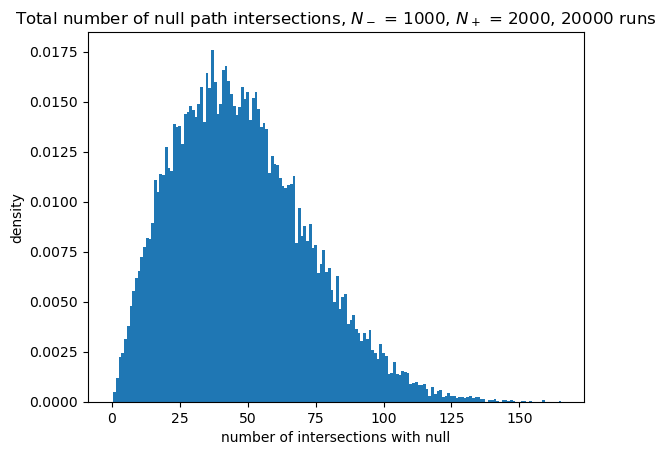

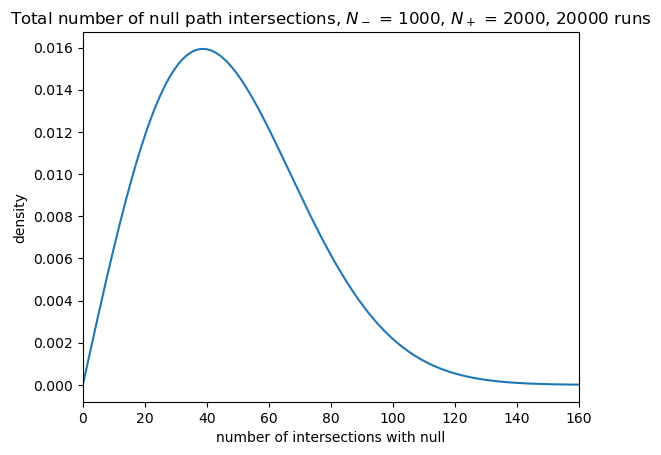

In [337]:
fig, ax = plt.subplots()
ax.hist(internum, bins = np.max(internum) + 1, density = True, range = [-0.5, np.max(internum) + 0.5])
ax.set_title(f"Total number of null path intersections, $N_-$ = {N_m}, $N_+$ = {N_p}, {M} runs")
ax.set_xlabel("number of intersections with null")
ax.set_ylabel("density")
plt.show()
fig, ax = plt.subplots()
ax.plot(ins)
ax.set_xlim([0,160])
ax.set_title(f"Total number of null path intersections, $N_-$ = {N_m}, $N_+$ = {N_p}, {M} runs")
ax.set_xlabel("number of intersections with null")
ax.set_ylabel("density")
plt.show()

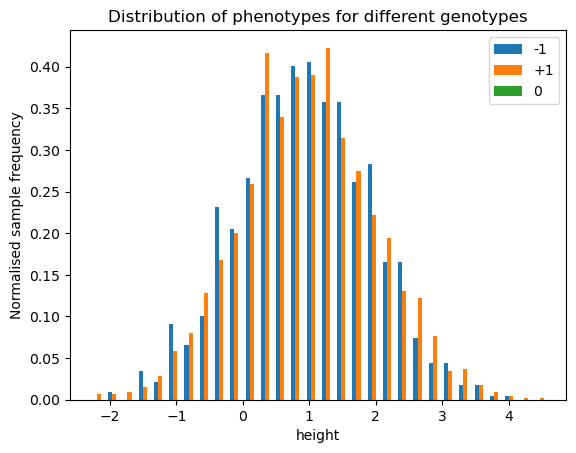

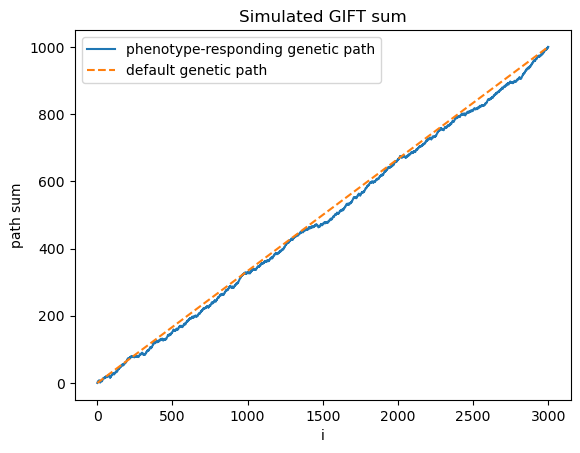

In [836]:
N_0 = 0
N_m = 1000
N_p = 2000
N = N_m + N_p + N_0

effect = 0.0002
mean = np.array([1+effect,1-effect,0]) 
var = np.array([1,1,1]) 

norm_path, pheno = gen_normal(mean, var, N_m, N_p, N_0)
default = np.arange(N+1) * (N_p - N_m) / N

norm_int_num = np.sum(default == norm_path)
norm_p = np.min([np.sum(ins[:norm_int_num+1]),np.sum(ins[norm_int_num:])])

plt.hist(pheno, density=True, bins = int(30), label=['-1','+1', '0'])
plt.xlabel("height")
plt.ylabel("Normalised sample frequency")
plt.title("Distribution of phenotypes for different genotypes")
plt.legend()
plt.savefig('Distribution of phenotypes for different genotypes.png',backend='pgf')

fig, ax = plt.subplots()
ax.plot(norm_path, label="phenotype-responding genetic path")
ax.plot([0,N], [0,N_p-N_m], linestyle='dashed', label = "default genetic path")
# ax.plot(age_path, label="age")

ax.set_ylabel("path sum")
ax.set_xlabel("i")
ax.set_title("Simulated GIFT sum")
plt.savefig('Simulated GIFT sum.png',backend='pgf')
plt.legend()
plt.show()

In [858]:
# effect = 0.1
# base_rate = 0.001
# M = 100

# msds = []
# for i in range(M):
#     age_path = gen_life_winter(effect, base_rate, N_m, N_p)
#     msds.append(np.mean((age_path - default)**2))
# mmsd = np.mean(msds)
# print(mmsd)

# norm_effect = 0.002
# mean = np.array([1+norm_effect,1-norm_effect,0])
# var = np.array([1,1,1])

# msds = []
# for i in range(M):
#     norm_path, pheno = gen_normal(mean, var, N_m, N_p, N_0)
#     msds.append(np.mean((norm_path - default)**2))
# mmsd = np.mean(msds)
# print(mmsd)

# fig, ax = plt.subplots()
# ax.plot(norm_path, label="phenotype-responding genetic path")
# ax.plot([0,N], [0,N_p-N_m], linestyle='dashed', label = "default genetic path")
# ax.plot(age_path, label="age")
# ax.legend()

In [ ]:
# base_rate = 0.001
# M = 10000

# ps = np.zeros([2, M])
# for j in range(M):
#     norm_path, _ = gen_normal(mean, var, N_m, N_p, N_0)
#     norm_int_num = np.sum(default == norm_path)
#     ps[0,j] = np.min([np.sum(ins[:norm_int_num+1]), np.sum(ins[norm_int_num:])])

#     age_path = gen_life_winter(effect, base_rate, N_m, N_p)
#     age_int_num = np.sum(default == age_path)
#     ps[1,j] = np.min([np.sum(ins[:age_int_num+1]), np.sum(ins[age_int_num:])])
# ps.sort(axis=1)

In [ ]:
# base_rate = 0.01
# N = N_m + N_p + N_0
# M = 4000
# default = np.arange(N+1) * (N_p - N_m) / N

# effects = np.linspace(0.1,0,6,endpoint=True)
# ps1 = np.zeros([2,len(effects), M])
# for i in range(len(effects)):
#     mean = np.array([0,effects[i],0])
#     var = np.array([1,1,1])
#     for j in range(M):
#         norm_path, _ = gen_normal(mean, var, N_m, N_p, N_0)
#         norm_int_num = np.sum(default == norm_path)
#         ps1[0,i,j] = np.min([np.sum(ins[:norm_int_num+1]), np.sum(ins[norm_int_num:])])

#         age_path = gen_life_winter(effects[i], base_rate, N_m, N_p)
#         age_int_num = np.sum(default == age_path)
#         ps1[1,i,j] = np.min([np.sum(ins[:age_int_num+1]), np.sum(ins[age_int_num:])])
# ps1.sort(axis=2)

C:\Users\prope\AppData\Local\Temp\ipykernel_16872\230342665.py:1: MatplotlibDeprecationWarning: Passing label as a length 6 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(ps[0].T, label=np.round(effects,5))


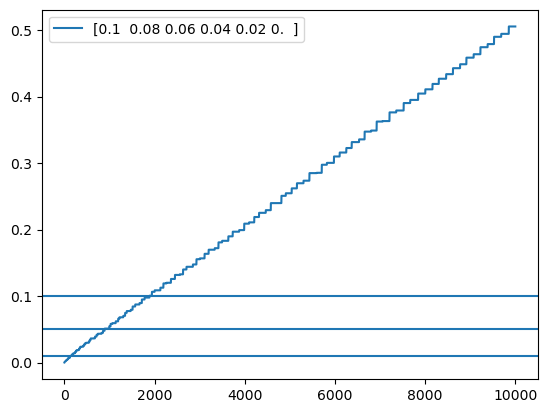

C:\Users\prope\AppData\Local\Temp\ipykernel_16872\230342665.py:9: MatplotlibDeprecationWarning: Passing label as a length 6 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(ps[1].T, label=np.round(effects,5))


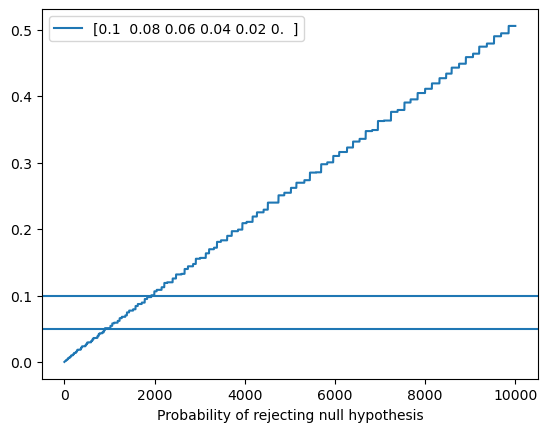

horizontal lines are the 0.05 and 0.1 p-value thresholds under the null hypothesis, so the diagonal is expected under null
The x-axis is the number of simulated paths which had a p-value less than the line
legend is effect size


In [ ]:
# plt.plot(ps[0].T, label=np.round(effects,5))
# plt.axhline(y=0.01)
# plt.axhline(y=0.05)
# plt.axhline(y=0.1)

# plt.legend()
# plt.show()

# plt.plot(ps[1].T, label=np.round(effects,5))
# plt.xlabel("Probability of rejecting null hypothesis")
# plt.axhline(y=0.05)
# plt.axhline(y=0.1)

# plt.legend()
# plt.show()

# print("horizontal lines are the 0.05 and 0.1 p-value thresholds under the null hypothesis, so the diagonal is expected under null")
# print("The x-axis is the number of simulated paths which had a p-value less than the line")
# print("legend is effect size")

In [ ]:
#3 variables
def path3(N_m, N_p, N_0, M):
    N = N_m + N_0 + N_p
    paths = np.ones([M,N])
    paths[:,N_p:N_p + N_0] *= 0
    paths[:,N_p+N_0:] *= -1
    paths = genn.permuted(paths,axis=1)
    paths = np.concat([[np.zeros(M)], np.cumsum(paths,axis=1).T]).T
    return paths

def intersection_density3(N_m, N_p, N_0, M): 
    N = N_p + N_m + N_0
    x0 = np.arange(N+1) * (N_p - N_m) / N
    intersections = np.zeros([M,N+1])
    x = path3(N_m, N_p, N_0, M)
    y = x - x0
    intersections = y == 0

    inter_number = np.sum(intersections[:], axis = 1) - 1
    inters = np.argwhere(intersections == 1).T[1]

    return inters, inter_number

In [877]:
# N_m = 5
# N_p = 50
# N_0 = 5
# N = N_m + N_p + N_0
# x,y = intersection_density3(N_m, N_p, N_0, 100000)
# print(x.shape)
# # print(x[:100])s
# plt.hist(x.T, bins = np.arange(N+2)-0.5, align='mid')
# plt.show()

Interesting property shown below: The expected number of intersections for a given ratio of $N_+$ and $N_-$ scales with $\sqrt{N}$ asymptotically, empirical proof below. We multiply $N$ by $m$ every iteration, and the expected number of intersections increases by a factor of $\sqrt m$ approximately.

In [878]:
q=20 
m = 2

print("prediction in limit", np.sqrt(m))

N_m = gen.integers(1,10).get()
N_p = gen.integers(1,10).get()

sums = np.zeros(1)
probs = null_intersection_exact(N_m, N_p)
sums[0] = sum(probs)

for j in range(q):
    N_m*=m
    N_p*=m
    probs = null_intersection_exact(N_m, N_p)
    sums = np.concatenate([sums,[np.sum(probs)]])
    print(f'iteration = {j}, ratio = {sums[-1] / sums[-2]}')

prediction in limit 1.4142135623730951
iteration = 0, ratio = 1.2039627039627039
iteration = 1, ratio = 1.2345737084433726
iteration = 2, ratio = 1.2669616879835632
iteration = 3, ratio = 1.2975594943079454
iteration = 4, ratio = 1.324297211568191
iteration = 5, ratio = 1.3463930424311608
iteration = 6, ratio = 1.3639132895912889
iteration = 7, ratio = 1.3773828820619098
iteration = 8, ratio = 1.3875031333147216
iteration = 9, ratio = 1.394979224981085
iteration = 10, ratio = 1.4004341446480295
iteration = 11, ratio = 1.404378830590808
iteration = 12, ratio = 1.4072130714193023
iteration = 13, ratio = 1.4092400799966096
iteration = 14, ratio = 1.410684997467051
iteration = 15, ratio = 1.4117125679605385


KeyboardInterrupt: 